<a href="https://colab.research.google.com/github/Akshaykumarmundrathi/Quantum_ML/blob/main/LIF_Izhikevich_SimulationCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Leaky Integrate and Fire model
# cheap
# easy
# ML

t = 0.0
dt = 1.0/ 100.0

v = -10.0
v_0 = -60.0 #milivolts
tau = 2.0

vs = []

In [ ]:
while t < 10.0:
  vs.append(v)
  dv = -(v-v_0) / tau
  v += dv * dt
  t += dt

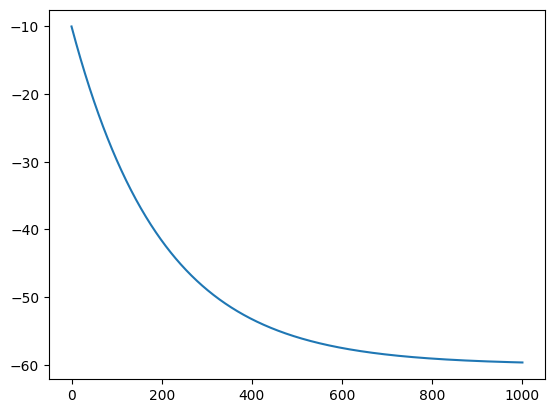

In [ ]:
plt.plot(vs)
plt.show()

In [ ]:
# With SPiking
t = 0.0
dt = 1.0/ 200.0

v = -50.0
v_0 = -60.0 #milivolts
tau = 2.0

v_thresh = 20.0

vs = []
spike_times = []

In [ ]:
while t < 70.0:
  vs.append(v)
  dv = -(v-v_0) / tau

  if t > 20.0 and t < 45.0:
    dv += 50.0 # adding Icurrent = 50 to spike inject

  v += dv * dt

  if v >= v_thresh:
    #spike
    spike_times.append(t)
    #reset
    v = v_0

  t += dt

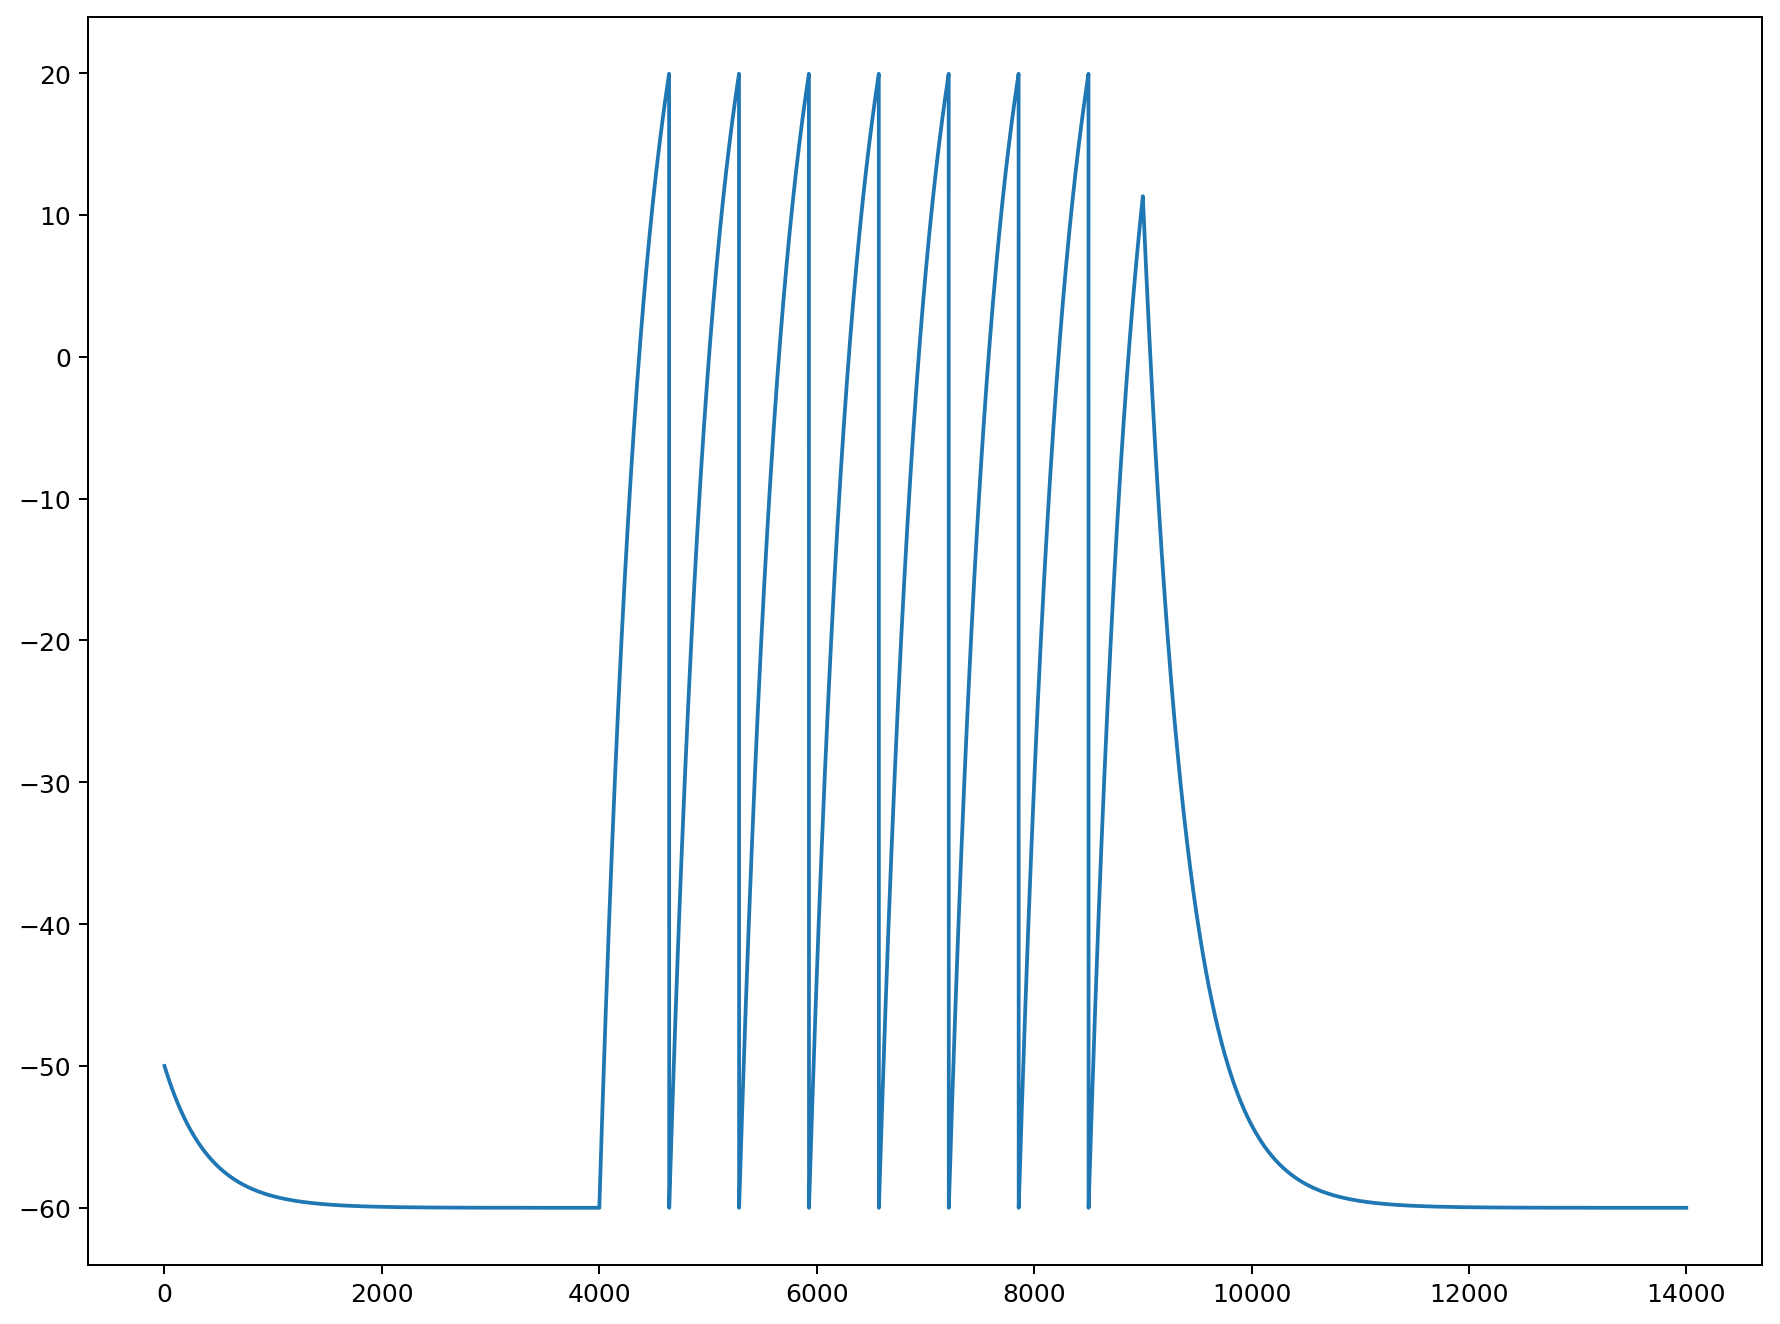

In [ ]:
fig = plt.figure(figsize = (12,9), dpi = 180)
plt.plot(vs)
plt.show()

In [ ]:
# Izhikevich Simple Neuron model
# v and u are recovery variables

t = 0.0
dt = 1.0/ 200.0

v = -55.0
#v_0 = -60.0 #milivolts
#tau = 2.0

v_thresh = 30.0

u = 0.0 # This variable can help reduce the rate of v to make it more realistic

# From Izhikevich paper
# Regular spiking numbers.
a = 0.02
b = 0.2
c = -65.0
d = 8.0

vs = []
spike_times = []

In [ ]:
while t < 70.0:
  vs.append(v)

  dv = (0.04 * v ** 2) + (5.0 * v) + 140.0 - u
  du = a * ((b*v) - u)

  if t > 20.0 and t < 45.0:
    dv += 50.0 # adding Icurrent = 50 to spike inject

  v += dv * dt
  u += du * dt

  if v >= v_thresh:
    #spike
    spike_times.append(t)

    #reset
    v = c
    u = u + d

  t += dt

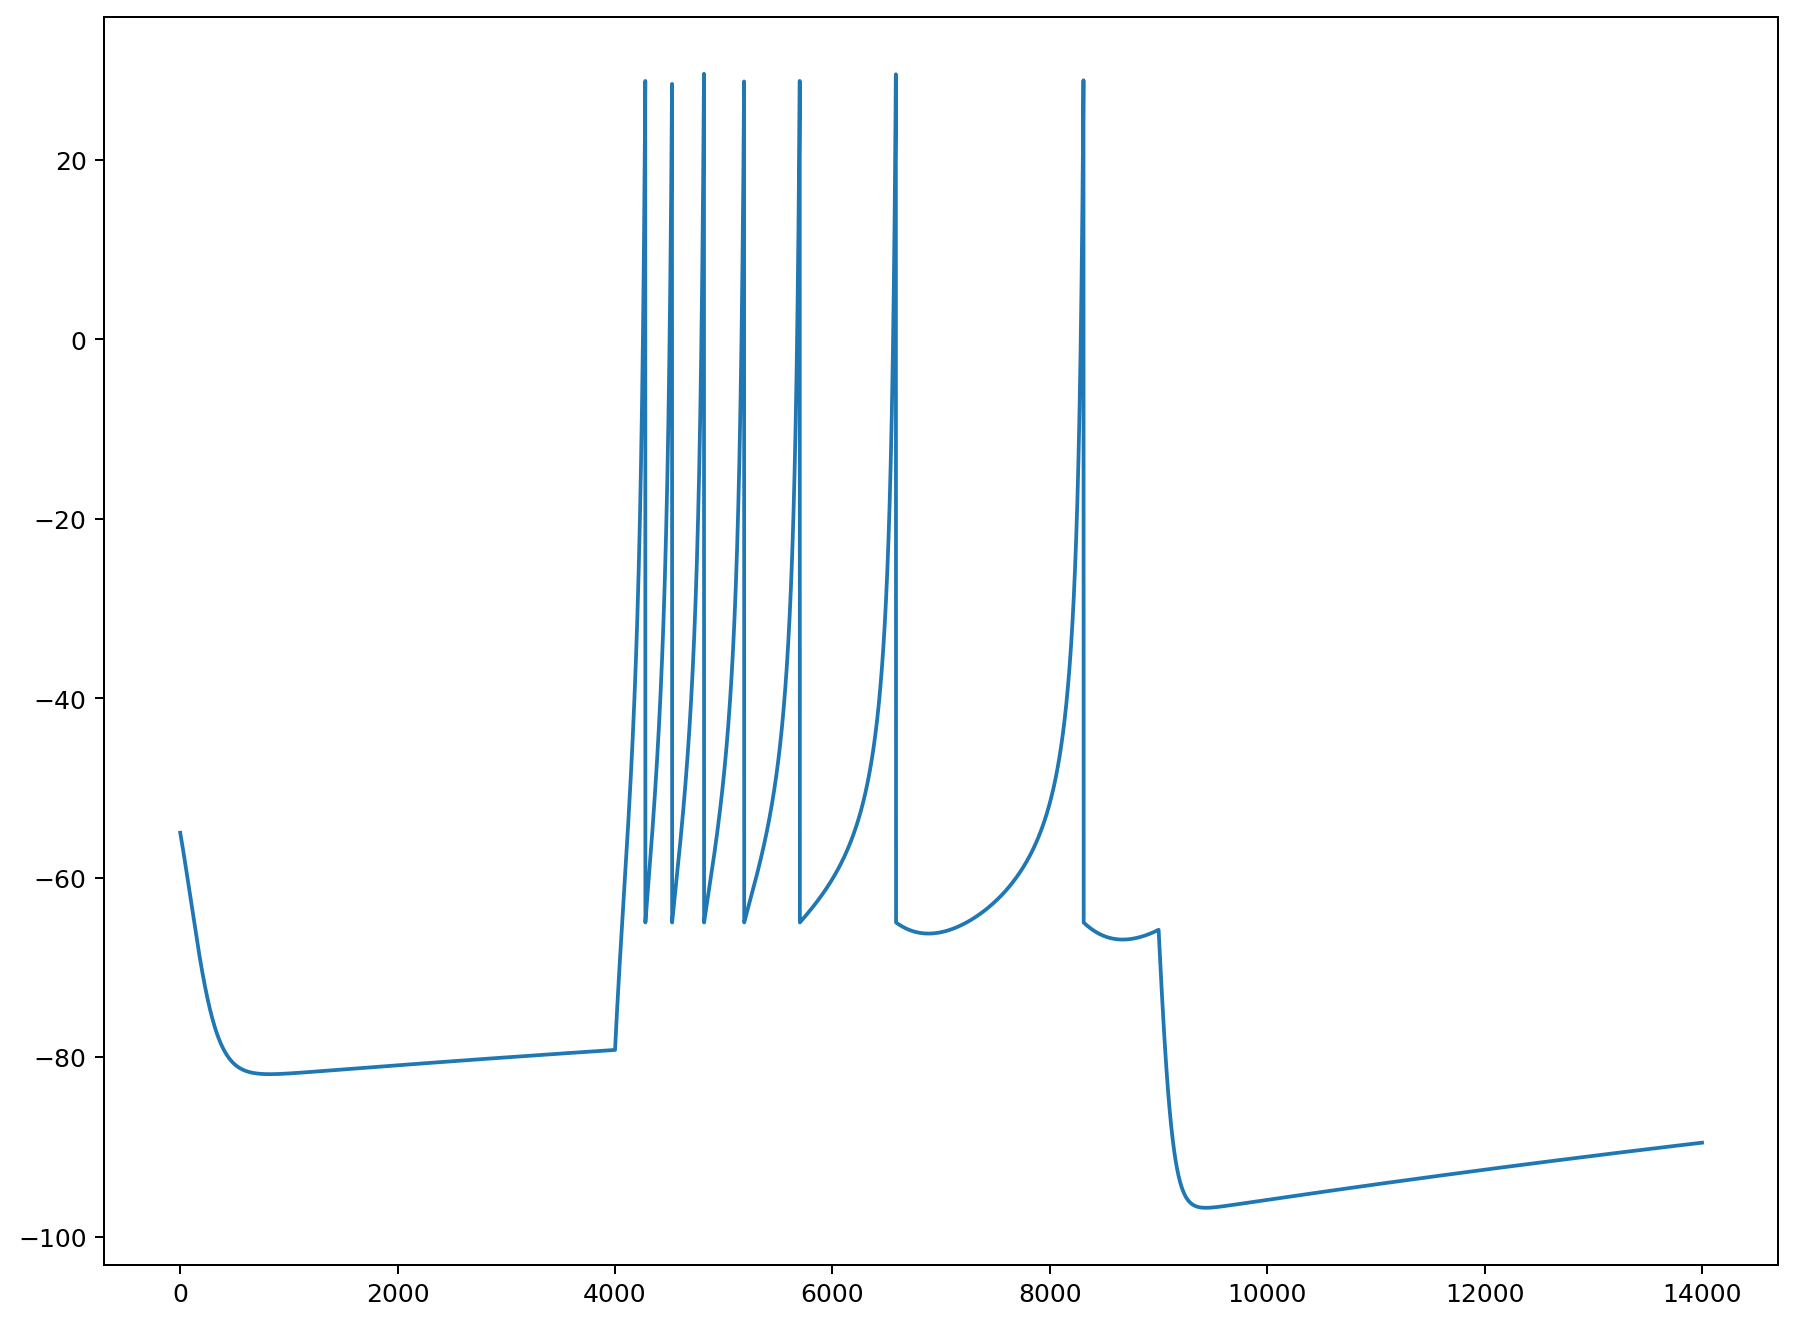

In [ ]:
fig = plt.figure(figsize = (12,9), dpi = 180)
plt.plot(vs)
plt.show()

In [ ]:
# Synapses
# Coding
# Information is contained in the firing rate of neuron (rate encoding)
# Also, relative timing of spikes: information (temporal encoding)
# Excitatory & inhibitory: some neurons produce spikes that makes other neurons fire more vs fire less
# Training
# 1. ANN conversion: map onto SNN neurons and map the weights
# 2. Backprop-like
# 3. Local rules synapses: Spike Timing Dependent Plasticity STDP
# Reinforcement learning, experiment with surroundings, exploration tradeoff
# Unsupervised learning rule: pattern recognition: mapping output to input: pattern recognition, feature detection
# LTP: Long term potentiation
# LTD: long term depreciation
# Reward or Dopamine modulation: STDP tags along with reward signal.
# If the reward signal is low, then STDP is not activated.
# If the reward signal is considerable, then STDP is activated

In [ ]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import time

In [ ]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format='retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")
my_layout = widgets.Layout()

In [ ]:
# @title Plotting functions
def my_raster_plot(range_t, spike_train, n):
  """Generates poisson trains

  Args:
    range_t     : time sequence
    spike_train : binary spike trains, with shape (N, Lt)
    n           : number of Poisson trains plot

  Returns:
    Raster_plot of the spike train
  """

  # Find the number of all the spike trains
  N = spike_train.shape[0]

  # n should be smaller than N:
  if n > N:
    print('The number n exceeds the size of spike trains')
    print('The number n is set to be the size of spike trains')
    n = N

  # Raster plot
  i = 0
  while i <= n:
    if spike_train[i, :].sum() > 0.:
      t_sp = range_t[spike_train[i, :] > 0.5]  # spike times
      plt.plot(t_sp, i * np.ones(len(t_sp)), 'k|', ms=10, markeredgewidth=2)
    i += 1
  plt.xlim([range_t[0], range_t[-1]])
  plt.ylim([-0.5, n + 0.5])
  plt.xlabel('Time (ms)')
  plt.ylabel('Neuron ID')
  plt.show()


def my_example_P(pre_spike_train_ex, pars, P):
  """Generates two plots (raster plot and LTP vs time plot)

  Args:
    pre_spike_train_ex     : spike-train
    pars : dictionary with the parameters
    P : LTP ratio

  Returns:
    my_example_P returns a rastert plot (top),
    and a LTP ratio across time (bottom)
  """
  spT = pre_spike_train_ex
  plt.figure(figsize=(7, 6))
  plt.subplot(211)
  color_set = ['red', 'blue', 'black', 'orange', 'cyan']
  for i in range(spT.shape[0]):
    t_sp = pars['range_t'][spT[i, :] > 0.5]   # spike times
    plt.plot(t_sp, i*np.ones(len(t_sp)), '|',
             color=color_set[i],
             ms=10, markeredgewidth=2)
  plt.xlabel('Time (ms)')
  plt.ylabel('Neuron ID')
  plt.xlim(0, 200)

  plt.subplot(212)
  for k in range(5):
    plt.plot(pars['range_t'], P[k, :], color=color_set[k], lw=1.5)
  plt.xlabel('Time (ms)')
  plt.ylabel('P(t)')
  plt.xlim(0, 200)

  plt.tight_layout()
  plt.show()


def mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW):
  plt.figure()
  plt.plot([-5 * tau_stdp, 5 * tau_stdp], [0, 0], 'k', linestyle=':')
  plt.plot([0, 0], [-A_minus, A_plus], 'k', linestyle=':')

  plt.plot(time_diff[time_diff <= 0], dW[time_diff <= 0], 'ro')
  plt.plot(time_diff[time_diff > 0], dW[time_diff > 0], 'bo')

  plt.xlabel(r't$_{\mathrm{pre}}$ - t$_{\mathrm{post}}$ (ms)')
  plt.ylabel(r'$\Delta$W', fontsize=12)
  plt.title('Biphasic STDP', fontsize=12, fontweight='bold')
  plt.show()

In [ ]:
# @title Helper functions

def default_pars_STDP(**kwargs):
  pars = {}

  # typical neuron parameters
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['V_init'] = -65.   # initial potential [mV]
  pars['V_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # STDP parameters
  pars['A_plus'] = 0.008                   # magnitude of LTP
  pars['A_minus'] = pars['A_plus'] * 1.10  # magnitude of LTD
  pars['tau_stdp'] = 20.                   # STDP time constant [ms]

  # simulation parameters
  pars['T'] = 400.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


def Poisson_generator(pars, rate, n, myseed=False):
  """Generates poisson trains

  Args:
    pars            : parameter dictionary
    rate            : noise amplitute [Hz]
    n               : number of Poisson trains
    myseed          : random seed. int or boolean

  Returns:
    pre_spike_train : spike train matrix, ith row represents whether
                      there is a spike in ith spike train over time
                      (1 if spike, 0 otherwise)
  """

  # Retrieve simulation parameters
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size

  # set random seed
  if myseed:
    np.random.seed(seed=myseed)
  else:
    np.random.seed()

  # generate uniformly distributed random variables
  u_rand = np.random.rand(n, Lt)

  # generate Poisson train
  poisson_train = 1. * (u_rand < rate * (dt / 1000.))

  return poisson_train

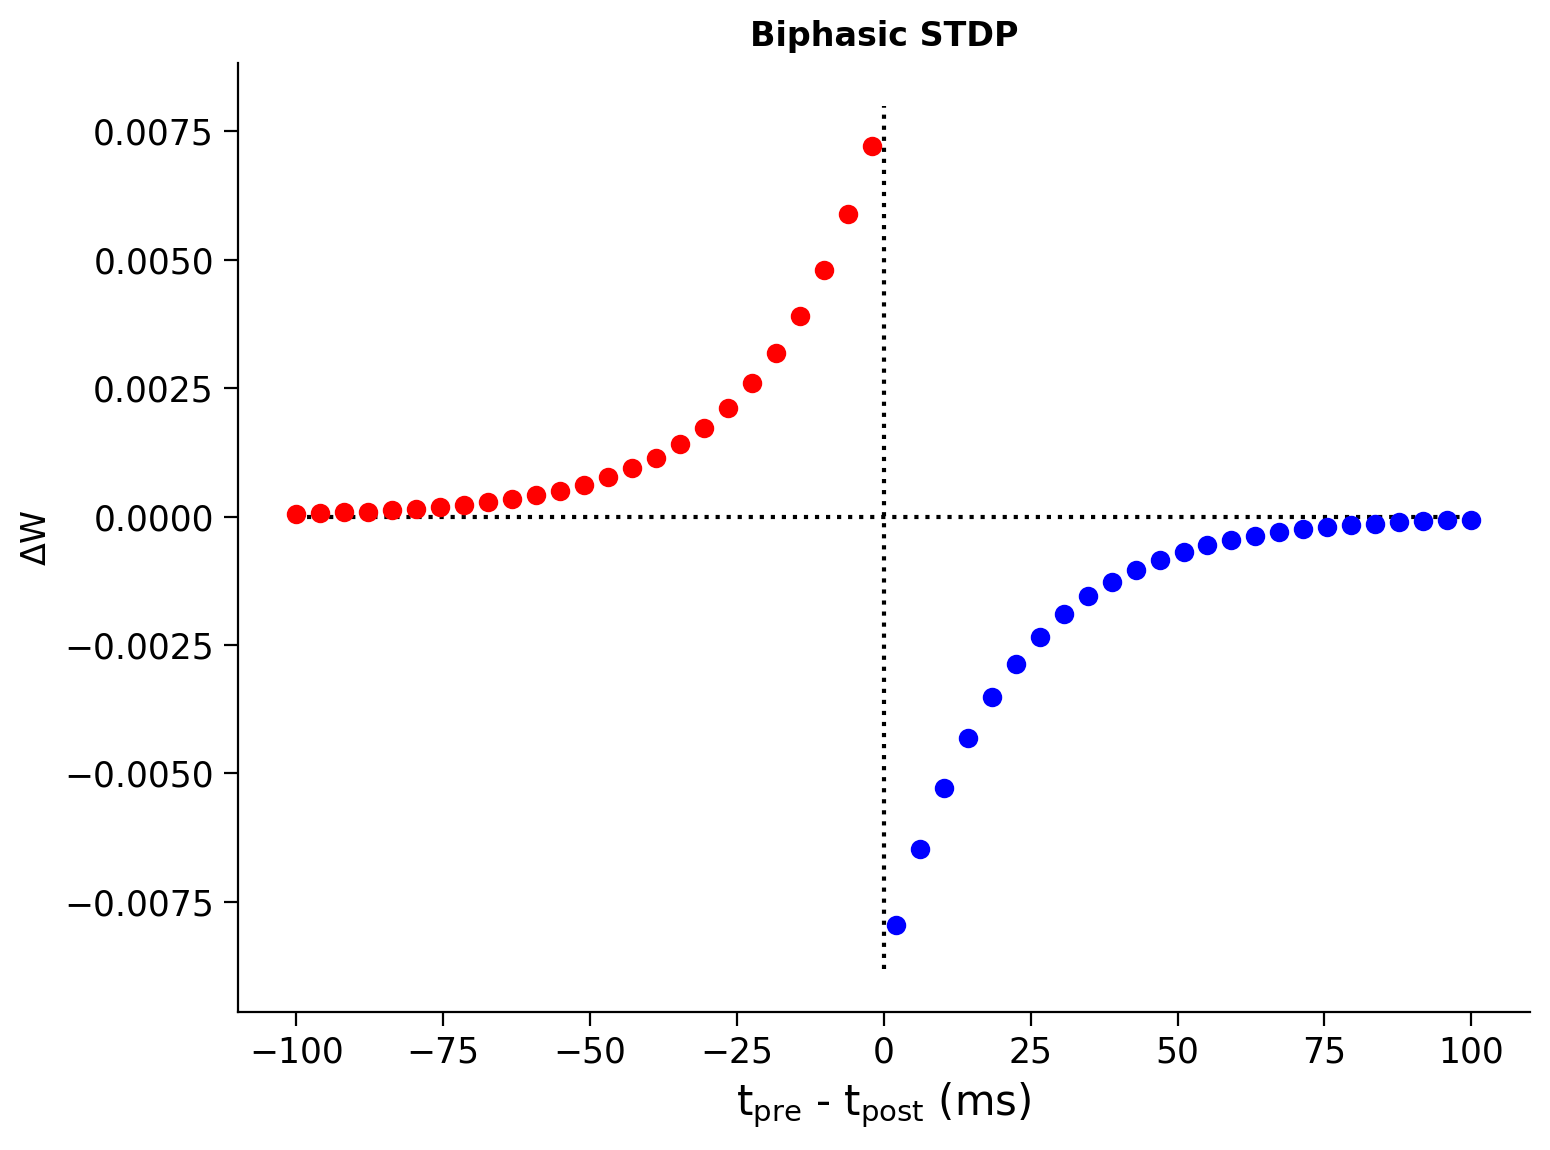

In [ ]:
def Delta_W(pars, A_plus, A_minus, tau_stdp):
  """
  Plot STDP biphasic exponential decaying function

  Args:
    pars       : parameter dictionary
    A_plus     : (float) maximum amount of synaptic modification
                 which occurs when the timing difference between pre- and
                 post-synaptic spikes is positive
    A_minus    : (float) maximum amount of synaptic modification
                 which occurs when the timing difference between pre- and
                 post-synaptic spikes is negative
    tau_stdp   : the ranges of pre-to-postsynaptic interspike intervals
                 over which synaptic strengthening or weakening occurs

  Returns:
    dW         : instantaneous change in weights
  """
  #######################################################################
  ## TODO for students: compute dP, then remove the NotImplementedError #
  # Fill out when you finish the function
  #raise NotImplementedError("Student exercise: compute dW, the change in weights!")
  #######################################################################
  # STDP change
  dW = np.zeros(len(time_diff))
  # Calculate dW for LTP
  dW[time_diff <= 0] = A_plus * np.exp(time_diff[time_diff <= 0] / tau_stdp)
  # Calculate dW for LTD
  dW[time_diff > 0] = -A_minus * np.exp(-time_diff[time_diff > 0] / tau_stdp)

  return dW


pars = default_pars_STDP()
# Get parameters
A_plus, A_minus, tau_stdp = pars['A_plus'], pars['A_minus'], pars['tau_stdp']
# pre_spike time - post_spike time
time_diff = np.linspace(-5 * tau_stdp, 5 * tau_stdp, 50)

dW = Delta_W(pars, A_plus, A_minus, tau_stdp)
mySTDP_plot(A_plus, A_minus, tau_stdp, time_diff, dW)